<a href="https://colab.research.google.com/github/2Randi/AIRBNB/blob/main/TER_ICO_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intégration d'ensembles de données annotées de vérification des faits

Cette version permet de créer la base de réference automatiquement avec **TF-IDF**

# Installation

In [1]:
from google.colab import drive
import sys
drive.mount('/content/gdrive/')
my_local_drive='/content/gdrive/My Drive/donnee'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

Mounted at /content/gdrive/
/content/gdrive/My Drive/donnee


'/content/gdrive/My Drive/donnee'

In [2]:
!pip install langdetect
!pip install contractions
!pip install wordcloud
!pip install -U spacy
!pip install scikit-learn
!pip install num2words

!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md
!python -m spacy download en_core_web_lg

!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=c487e3310f760a3730161731fd9bc88da456db4f6f9f9925c24d95b60940c38e
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=ae19cee9479b5a195c32b67c9053192db15a4e072a881a76a827090e9c2b59be
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import contractions
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import re
import pandas as pd
import numpy as np
import sklearn

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

import pickle
import string
import time
import base64
# librairie BeautifulSoup
from bs4 import BeautifulSoup

import wordcloud
## detection de language

import langdetect

import spacy
from spacy.tokens import Span
from scipy.stats import randint

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk import RegexpParser
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Chargement des données

In [5]:
ckgF = pd.read_csv('claimskg_false_f.csv');
ckgR = pd.read_csv('claimskg_true_f.csv');

fnnF = pd.read_csv('politifact_fake.csv', sep=';');
fnnR = pd.read_csv('politifact_real.csv');

In [6]:
#Concatenation des datasets
fnnR['ratingName']=True
fnnF['ratingName']=False

fnn = pd.concat([fnnR,fnnF], axis=0)
ckg = pd.concat([ckgR, ckgF], axis=0)

In [7]:
#Suppression doublons
ckg.drop_duplicates(inplace = True)
fnn.drop_duplicates(inplace = True)

In [8]:
#Suppression des valeurs manquants NaN
ckg.dropna(subset=['headline', 'ratingName'])
fnn.dropna(subset=['title', 'ratingName'])

,id,news_url,title,tweet_ids,ratingName
0,politifact14984,http://www.nfib-sbet.org/,National Federation of Independent Business,967132259869487105\t967164368768196609\t967215...,True
1,politifact12944,http://www.cq.com/doc/newsmakertranscripts-494...,comments in Fayetteville NC,942953459\t8980098198\t16253717352\t1668513250...,True
2,politifact333,https://web.archive.org/web/20080204072132/htt...,"Romney makes pitch, hoping to close deal : Ele...",NaN,True
3,politifact4358,https://web.archive.org/web/20110811143753/htt...,Democratic Leaders Say House Democrats Are Uni...,NaN,True
4,politifact779,https://web.archive.org/web/20070820164107/htt...,"Budget of the United States Government, FY 2008",89804710374154240\t91270460595109888\t96039619...,True
...,...,...,...,...,...
426,politifact14944,http://thehill.com/homenews/senate/369928-who-...,Who is affected by the government shutdown?,954602090462146560\t954602093171609600\t954650...,False
427,politifact14071,https://web.archive.org/web/20170322070001/htt...,Lindsey Graham Threatens To Convert To Democra...,740351669834244096\t740391312277573632\t740474...,False
428,politifact13577,http://archive.is/DQqCx,ELECTORAL COLLEGE ELECTOR COMMITS SUICIDE TO A...,810939651900907520\t814738996706164737\t814917...,False
429,politifact13560,politicono.com/palin-calls-boycott-mall-americ...,Sarah Palin Calls To Boycott Mall Of America B...,805216591424212993\t805222830023540736\t805223...,False


In [9]:
print(" taille:",ckg.size)
print(" taille:",fnn.size)

 taille: 280000
 taille: 5275


In [ ]:
print(" Lignes et colonne:",ckg.shape)
print(" Lignes et colonne:",fnn.shape)

 Lignes et colonne: (20000, 14)
 Lignes et colonne: (1055, 5)


In [ ]:
print(" === les six premières lignes ===")
ckg.head(6)

fnn.head(6)

 === les six premières lignes ===


,id,news_url,title,tweet_ids,ratingName
0,politifact14984,http://www.nfib-sbet.org/,National Federation of Independent Business,967132259869487105\t967164368768196609\t967215...,True
1,politifact12944,http://www.cq.com/doc/newsmakertranscripts-494...,comments in Fayetteville NC,942953459\t8980098198\t16253717352\t1668513250...,True
2,politifact333,https://web.archive.org/web/20080204072132/htt...,"Romney makes pitch, hoping to close deal : Ele...",NaN,True
3,politifact4358,https://web.archive.org/web/20110811143753/htt...,Democratic Leaders Say House Democrats Are Uni...,NaN,True
4,politifact779,https://web.archive.org/web/20070820164107/htt...,"Budget of the United States Government, FY 2008",89804710374154240\t91270460595109888\t96039619...,True
5,politifact14064,http://www.politifact.com/truth-o-meter/statem...,Donald Trump exaggerates when he says China ha...,690248006399049728\t690254026663821312\t690276...,True


In [ ]:
print(" === Les trois dernières lignes  ===")
display(ckg.tail(6))
display(fnn.tail(6))

 === Les trois dernières lignes  ===


,id,text,date,truthRating,ratingName,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link,language
9994,http://data.gesis.org/claimskg/claim_review/1c...,Hillary Clinton invented ISIS with her stupid ...,2016-07-17,1,False,Unknown,Donald Trump wrongly blames Hillary Clinton fo...,"10,000 troops,2002,2004,2006,2011,2013,2014,60...","Hillary Clinton,ISIS",http://data.gesis.org/claimskg/keyword/71ade47...,politifact,http://www.politifact.com,https://www.politifact.com/factchecks/2016/jul...,English
9995,http://data.gesis.org/claimskg/claim_review/0c...,Says he was the first person to call for invok...,2020-09-02,1,False,Unknown,Joe Biden wrong about how early he called to i...,"1950,Alex Azar,Azar,Biden,Chris Wallace,Congre...",Defense Production Act,http://data.gesis.org/claimskg/keyword/566bd8a...,politifact,http://www.politifact.com,https://www.politifact.com/factchecks/2020/sep...,English
9996,http://data.gesis.org/claimskg/claim_review/88...,Photo shows a clearly intoxicated Kamala Harri...,2020-10-24,1,False,Unknown,"No, photo doesn’t show an intoxicated Kamala H...","2020,California,Chatbot,Cleveland airport,Demo...","Cleveland airport,Kamala Harris",http://data.gesis.org/claimskg/keyword/f940515...,politifact,http://www.politifact.com,https://www.politifact.com/factchecks/2020/oct...,English
9997,http://data.gesis.org/claimskg/claim_review/4d...,A case before Washington’s Supreme Court seeks...,2018-01-03,1,False,Unknown,Unions would suffer but not end because of Sup...,"AFSCME,Abood v. Detroit Board of Education,Alb...",public labor unions,http://data.gesis.org/claimskg/keyword/ea88714...,politifact,http://www.politifact.com,https://www.politifact.com/factchecks/2018/jan...,English
9998,http://data.gesis.org/claimskg/claim_review/f3...,NFL will fly a ‘Black Lives Matter’ flag under...,2020-06-10,1,False,Unknown,NFL is not planning to fly a Black Lives Matte...,"2016,2019,American flag,Black Lives Matter,Bla...","American flag,Black Lives Matter,NFL",http://data.gesis.org/claimskg/keyword/22a3e06...,politifact,http://www.politifact.com,https://www.politifact.com/factchecks/2020/jun...,English
9999,http://data.gesis.org/claimskg/claim_review/17...,Last year was one of the deadliest years ever ...,2017-05-19,1,False,Unknown,Was 2016 'one of the deadliest years ever' for...,"2016,Felonious,North Carolina,PolitiFact,Prohi...",NaN,http://data.gesis.org/claimskg/keyword/508cb85...,politifact,http://www.politifact.com,https://www.politifact.com/factchecks/2017/may...,English


,id,news_url,title,tweet_ids,ratingName
425,politifact14362,dailyfeed.news/russian-mansions-obama-seized-w...,BUSTED: Russian Mansions Obama Seized Were Mea...,885291087170088962\t885297352214491136\t885316...,False
426,politifact14944,http://thehill.com/homenews/senate/369928-who-...,Who is affected by the government shutdown?,954602090462146560\t954602093171609600\t954650...,False
427,politifact14071,https://web.archive.org/web/20170322070001/htt...,Lindsey Graham Threatens To Convert To Democra...,740351669834244096\t740391312277573632\t740474...,False
428,politifact13577,http://archive.is/DQqCx,ELECTORAL COLLEGE ELECTOR COMMITS SUICIDE TO A...,810939651900907520\t814738996706164737\t814917...,False
429,politifact13560,politicono.com/palin-calls-boycott-mall-americ...,Sarah Palin Calls To Boycott Mall Of America B...,805216591424212993\t805222830023540736\t805223...,False
430,politifact15030,https://theglobalheadlines.net/breaking-intel-...,Account Suspended,934217740692443136\t934217839816445952\t934217...,False


In [ ]:
print ('Pour connaître les informations qui sont catégorielles')
print(ckg.info())
print(fnn.info())


Pour connaître les informations qui sont catégorielles
<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      20000 non-null  object
 1   text                    20000 non-null  object
 2   date                    20000 non-null  object
 3   truthRating             20000 non-null  int64 
 4   ratingName              20000 non-null  bool  
 5   author                  20000 non-null  object
 6   headline                20000 non-null  object
 7   named_entities_claim    19973 non-null  object
 8   named_entities_article  17426 non-null  object
 9   keywords                20000 non-null  object
 10  source                  20000 non-null  object
 11  sourceURL               20000 non-null  object
 12  link                    20000 non-null  object
 13  language                20000 non-null  object
dtypes: bo

Copie

In [12]:
ckg_clean = ckg.copy()
fnn_clean = fnn.copy()

ckg_brute = ckg.copy()
fnn_brute = fnn.copy()

# Visualisation des données

WORD CLOUD

# Nettoyage des données

Fonction permettant de prétraiter les données.

 Étendre les contractions, Enlever la ponctuation et mettre en minuscules, Enlever les nombres, Enlever les stopwords, lemmatisation et stemming

In [13]:
stop_words = set(stopwords.words('english'))

def MyCleanText(df_column,
               lowercase=False, # mettre en minuscule
               removestopwords=False, # supprimer les stopwords
               removedigit=False, # supprimer les nombres
               getstemmer=False, # conserver la racine des termes
               getlemmatisation=False # lematisation des termes
              ):

    cleaned_texts = []  # Initialiser une liste pour stocker les textes nettoyés

    for X in df_column:  # Parcourir chaque ligne de la colonne du DataFrame
        sentence = str(X)

        # suppression des caractères spéciaux
        sentence = re.sub(r'[^\w\s]',' ', sentence)
        # suppression de tous les caractères uniques
        sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
        # substitution des espaces multiples par un seul espace
        sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

        # decoupage en mots
        tokens = word_tokenize(sentence)
        if lowercase:
            tokens = [token.lower() for token in tokens]

        # suppression ponctuation
        table = str.maketrans('', '', string.punctuation)
        words = [token.translate(table) for token in tokens]

        # suppression des tokens non alphabetique ou numerique
        words = [word for word in words if word.isalnum()]

        # suppression des tokens numerique
        if removedigit:
            words = [word for word in words if not word.isdigit()]

        # suppression des stopwords
        if removestopwords:
            words = [word for word in words if not word in stop_words]

        # lemmatisation
        if getlemmatisation:
            lemmatizer=WordNetLemmatizer()
            words = [lemmatizer.lemmatize(word)for word in words]

        # racinisation
        if getstemmer:
            ps = PorterStemmer()
            words=[ps.stem(word) for word in words]


        sentence= ' '.join(words)
        cleaned_texts.append(sentence)
    return cleaned_texts

In [14]:
ckg_clean.headline =MyCleanText(ckg_clean['headline'], lowercase=True,
                                removestopwords=True,
                                removedigit=True,
                                getstemmer=True,
                                getlemmatisation=True)


In [15]:
fnn_clean.title =MyCleanText(fnn_clean['title'], lowercase=True,
                                removestopwords=True,
                                removedigit=True,
                                getstemmer=True,
                                getlemmatisation=True)


Les jeux de données suite au phase du preprocessing

In [16]:
ckg_clean['headline'].iloc[0]

'nami ohio leader terri russel say peopl mental ill die year earlier averag without'

In [17]:
fnn_clean.title

0                             nation feder independ busi
1                                  comment fayettevil nc
2      romney make pitch hope close deal elect rocki ...
3      democrat leader say hous democrat unit gop def...
4                            budget unit state govern fy
                             ...                        
426                               affect govern shutdown
427    lindsey graham threaten convert democrat repub...
428    elector colleg elector commit suicid avoid vot...
429    sarah palin call boycott mall america santa al...
430                                      account suspend
Name: title, Length: 1055, dtype: object

# Similarité textuelle

## Calcul similarité pour tout les couples possible

Rechercher couple (ClaimsKG, FakeNewsNet)

Vectorisation : TF-IDF

**donnée utilisé: donnée clean**

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

ckg_texts = ckg_clean['headline'].tolist()
fnn_texts = fnn_clean['title'].tolist()

matrix_ckg = tfidf_vectorizer.fit_transform(ckg_texts)
matrix_fnn = tfidf_vectorizer.transform(fnn_texts)

similarities = cosine_similarity(matrix_ckg, matrix_fnn)

threshold = 0.3

similar_pairs = []

for i in range(len(ckg_texts)):
    for j in range(len(fnn_texts)):
        similarity_score = similarities[i][j]
        if similarity_score >= threshold:
            ckg_text = ckg_texts[i]
            fnn_text = fnn_texts[j]
            similar_pairs.append((i, j, ckg_text, fnn_text, similarity_score))

base_1 = pd.DataFrame(similar_pairs, columns=['Index_ckg', 'Index_fnn', 'ckg', 'fnn', 'Similarity'])


In [20]:
base_1.drop_duplicates(inplace = True, subset=['ckg', 'fnn', 'Similarity'])

In [21]:
base_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3479 entries, 0 to 8361
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Index_ckg   3479 non-null   int64  
 1   Index_fnn   3479 non-null   int64  
 2   ckg         3479 non-null   object 
 3   fnn         3479 non-null   object 
 4   Similarity  3479 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 163.1+ KB


**donnée utilisé: donnée brute**

In [22]:
tfidf_vectorizer = TfidfVectorizer()

ckg_texts = ckg_brute['headline'].fillna('').tolist()
fnn_texts = fnn_brute['title'].fillna('').tolist()

matrix_ckg = tfidf_vectorizer.fit_transform(ckg_texts)
matrix_fnn = tfidf_vectorizer.transform(fnn_texts)

similarities = cosine_similarity(matrix_ckg, matrix_fnn)

threshold = 0.3

similar_pairs = []

for i in range(len(ckg_texts)):
    for j in range(len(fnn_texts)):
        similarity_score = similarities[i][j]
        if similarity_score >= threshold:
            ckg_text = ckg_texts[i]
            fnn_text = fnn_texts[j]
            similar_pairs.append((i, j, ckg_text, fnn_text, similarity_score))

base_2 = pd.DataFrame(similar_pairs, columns=['Index_ckg', 'Index_fnn', 'ckg', 'fnn', 'Similarity'])

In [23]:
base_2.drop_duplicates(inplace = True, subset=['ckg', 'fnn', 'Similarity'])

In [24]:
print('=== Comparaison des jeux de données prétraitées et non prétraitées === \n')
print('couple de CKG et FNN avec donnée clean, similarité cosinus >=0.3 : ', len(base_1))
print('couple de CKG et FNN avec donnée brute, similarité cosinus >=0.3 : ', len(base_2))

=== Comparaison des jeux de données prétraitées et non prétraitées === 

couple de CKG et FNN avec donnée clean, similarité cosinus >=0.3 :  3479
couple de CKG et FNN avec donnée brute, similarité cosinus >=0.3 :  1630


## Calcul similarité par topic

Recherche des couples de ClaimsKG et FakeNewsNet qui ont les mêmes **Topic**


In [ ]:
"""
Utilisation de LatentDirichletAllocation LDA pour la recherche de Topic
import gensim
from gensim import corpora
from gensim.models import LdaModel

headline = ckg['headline'].tolist()

# Création du dictionnaire et du corpus
dictionary = corpora.Dictionary([title.split() for title in headline])
corpus = [dictionary.doc2bow(text.split()) for text in headline]

# Entraînement du modèle LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=42, passes=10)
"""

Création de **vocabulaire** pour les topics

In [25]:
import nltk
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [26]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.tag import pos_tag

# Définir les mots clés pour chaque catégorie
politique_words = ['politic', 'elect', 'president', 'congress', 'govern', 'socialist', 'legislat', 'democrati', 'campaign']
economie_words = ['econom', 'market', 'financ', 'business', 'trade', 'inflation', 'budget', 'tax']
sociales_words = ['welfar', 'poverti', 'healthcar', 'educ', 'immigr', 'discrimin', 'refuge', 'crimin', 'homeless']

# Fonction pour extraire les vocabulaires en fonction des mots-clés spécifiés
def extract_vocabulary(df, words):
    vocabulary = []
    for headline in df['headline']:
        tokens = word_tokenize(headline)
        pos_tags = pos_tag(tokens)
        nouns = [word.lower() for word, pos in pos_tags if pos.startswith('NN')]
        vocabulary.extend([word for word in nouns if any(keyword in word for keyword in words)])
    return set(vocabulary)

# Extraire les vocabulaires pour chaque catégorie
politique_vocabulary = extract_vocabulary(ckg_clean, politique_words)
economie_vocabulary = extract_vocabulary(ckg_clean, economie_words)
sociales_vocabulary = extract_vocabulary(ckg_clean, sociales_words)

# Créer un DataFrame avec les vocabulaires et les sujets correspondants
voc = pd.DataFrame({
    'vocabulary': [', '.join(politique_vocabulary), ', '.join(economie_vocabulary), ', '.join(sociales_vocabulary)],
    'Topic': ['Political', 'Economic', 'Social']
})


In [27]:
print(voc[voc['Topic'] == 'Economic'])

                                          vocabulary     Topic
1  telemarket, taxi, budget, financi, econom, ref...  Economic


**Assigner un topic a chaque 'headline' de CKG**

In [28]:
from collections import defaultdict

# dictionnaire pour mapper les mots clés aux sujets
keyword_to_topic = defaultdict(str)
for index, row in voc.iterrows():
    for word in row['vocabulary'].split(', '):
        keyword_to_topic[word] = row['Topic']

# Fonction pour attribuer le sujet à un titre en fonction des mots clés
def assign_topic(headline):
    for word in headline.split():
        if word.lower() in keyword_to_topic:
            return keyword_to_topic[word.lower()]

ckg_clean['topic'] = ckg_clean['headline'].apply(assign_topic)


# Supprimer les lignes où le sujet est None (aucun sujet correspondant trouvé)
topic_ckg = ckg_clean.dropna(subset=['topic'])

ckg_topic = topic_ckg[['headline', 'topic']].copy()

ckg_topic['indice_ckg'] = topic_ckg.index


In [29]:
ckg_topic.topic

1       Political
7       Political
8        Economic
10       Economic
13         Social
          ...    
9982     Economic
9983     Economic
9985     Economic
9986    Political
9987     Economic
Name: topic, Length: 4332, dtype: object

In [30]:
print ('Statistique')

display(ckg_topic['topic'].describe())

Statistique


count         4332
unique           3
top       Economic
freq          1763
Name: topic, dtype: object

Répartition des topics de CKG

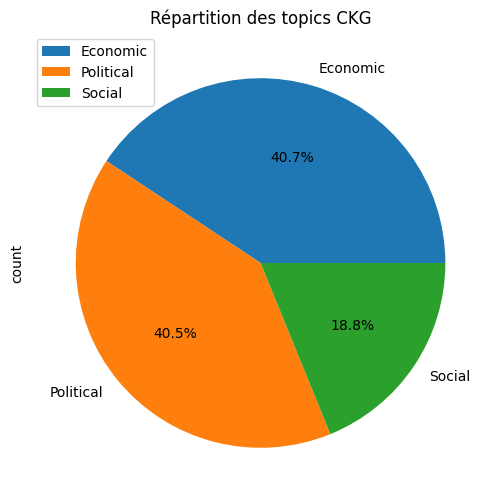

In [44]:
counts = ckg_topic['topic'].value_counts()
pourcentages = counts / counts.sum() * 100

ckg_topic['topic'].value_counts().plot(kind='pie',
                                       figsize=(6, 6),
                                       title='Répartition des topics CKG',
                                       fontsize=10,
                                       autopct='%1.1f%%',
                                       legend=True)
plt.legend(loc='upper left')
plt.show()

In [32]:
len(ckg_topic)

4332

####Classification des FNN par topic

*LogisticRegression*

In [33]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

seed = 27
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)


In [34]:
lbl = LabelEncoder()
y = lbl.fit_transform(ckg_topic['topic'])

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(ckg_topic['headline'])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=7)

LR = LogisticRegression(max_iter=1000)

LR.fit(X_train, y_train)

y_pred = LR.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on test set:', accuracy)

cv_scores1 = cross_val_score(LR, X, y, cv=skf)

print('Cross-validation scores:', cv_scores1)
print('Mean cross-validation score:', cv_scores1.mean())
print('Classification Report on test set:')
print(classification_report(y_test, y_pred, target_names=lbl.classes_))

Accuracy on test set: 0.9919261822376009
Cross-validation scores: [0.99077278 0.98500577 0.99538106 0.99076212 0.98845266]
Mean cross-validation score: 0.9900748779337846
Classification Report on test set:
              precision    recall  f1-score   support

    Economic       0.99      0.99      0.99       344
   Political       0.99      0.99      0.99       360
      Social       0.98      0.99      0.99       163

    accuracy                           0.99       867
   macro avg       0.99      0.99      0.99       867
weighted avg       0.99      0.99      0.99       867



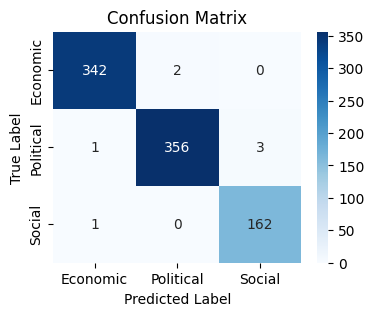

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lbl.classes_, yticklabels=lbl.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

*MultinomialNB*

In [36]:
lbl = LabelEncoder()
y = lbl.fit_transform(ckg_topic['topic'])

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(ckg_topic['headline'])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=7)

MNB = MultinomialNB()

MNB.fit(X_train, y_train)

y_pred = MNB.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on test set:', accuracy)

cv_scores2 = cross_val_score(MNB, X, y, cv=skf)

print('Cross-validation scores:', cv_scores2)
print('Mean cross-validation score:', cv_scores2.mean())
print('Classification Report on test set:')
print(classification_report(y_test, y_pred, target_names=lbl.classes_))

Accuracy on test set: 0.9342560553633218
Cross-validation scores: [0.94232987 0.92272203 0.93648961 0.93879908 0.93187067]
Mean cross-validation score: 0.9344422512925833
Classification Report on test set:
              precision    recall  f1-score   support

    Economic       0.92      0.97      0.94       344
   Political       0.93      0.96      0.95       360
      Social       0.97      0.81      0.88       163

    accuracy                           0.93       867
   macro avg       0.94      0.91      0.92       867
weighted avg       0.94      0.93      0.93       867



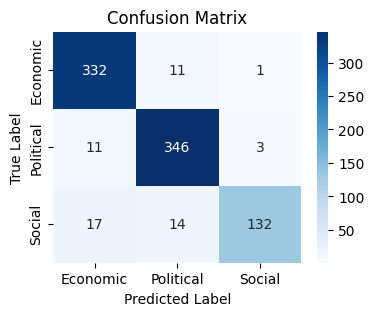

In [37]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lbl.classes_, yticklabels=lbl.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

*SVM*

In [38]:
lbl = LabelEncoder()
y = lbl.fit_transform(ckg_topic['topic'])

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(ckg_topic['headline'])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=7)

SVM = SVC()

SVM.fit(X_train, y_train)

y_pred = SVM.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on test set:', accuracy)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

cv_scores3 = cross_val_score(SVM, X, y, cv=skf)

print('Cross-validation scores:', cv_scores3)
print('Mean cross-validation score:', cv_scores3.mean())
print('Classification Report on test set:')
print(classification_report(y_test, y_pred, target_names=lbl.classes_))

Accuracy on test set: 0.9907727797001153
Cross-validation scores: [0.98961938 0.98615917 0.98614319 0.98845266 0.99422633]
Mean cross-validation score: 0.9889201435226992
Classification Report on test set:
              precision    recall  f1-score   support

    Economic       1.00      0.99      1.00       344
   Political       0.99      0.99      0.99       360
      Social       0.98      0.99      0.98       163

    accuracy                           0.99       867
   macro avg       0.99      0.99      0.99       867
weighted avg       0.99      0.99      0.99       867



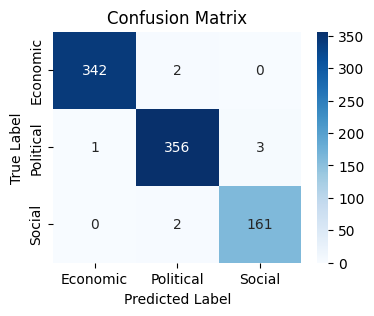

In [39]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lbl.classes_, yticklabels=lbl.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Fonction pour assigner au FNN un topic à l'aide du model de classification

In [40]:
def assign_topics(df_column, vectorizer, model, label_encoder):
    X_new = vectorizer.transform(df_column)
    predicted_topics = model.predict(X_new)
    predicted_topics_names = label_encoder.inverse_transform(predicted_topics)

    df_predicted_topics = pd.DataFrame({
        'title': df_column,
        'topic': predicted_topics_names
    })

    return df_predicted_topics

In [41]:
fnn_topic = assign_topics(fnn_clean['title'], vectorizer, LR, lbl)


Répatition des topics de FNN

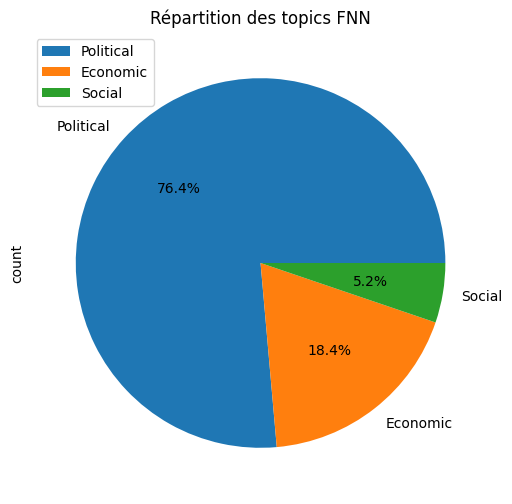

In [43]:
counts = fnn_topic['topic'].value_counts()
pourcentages = counts / counts.sum() * 100

fnn_topic['topic'].value_counts().plot(kind='pie',
                                       figsize=(6, 6),
                                       title='Répartition des topics FNN',
                                       fontsize=10,
                                       autopct='%1.1f%%',
                                       legend=True)
plt.legend(loc='upper left')
plt.show()

Séparation des jeux de données classifiées en fonction des topics

In [45]:
# Créer des dataframes séparés pour chaque sujet
ckg_0 = ckg_topic[ckg_topic['topic'] == 'Political'].copy()
ckg_1 = ckg_topic[ckg_topic['topic'] == 'Economic'].copy()
ckg_2 = ckg_topic[ckg_topic['topic'] == 'Social'].copy()


In [ ]:
ckg_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1753 entries, 1 to 9986
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   headline    1753 non-null   object
 1   topic       1753 non-null   object
 2   indice_ckg  1753 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 54.8+ KB


In [46]:
# Créer des dataframes séparés pour chaque sujet
fnn_0 = fnn_topic[fnn_topic['topic'] == 'Political'].copy()
fnn_1 = fnn_topic[fnn_topic['topic'] == 'Economic'].copy()
fnn_2 = fnn_topic[fnn_topic['topic'] == 'Social'].copy()


In [47]:
len(ckg_1)

1763

In [48]:
len(fnn_2)

55

###calcul similarité entre les 2 jeux de données par topic

In [90]:
def calculate_similarity(ckg, fnn):

    vectorizer = TfidfVectorizer()

    ckg_list = ckg.tolist()
    fnn_list = fnn.tolist()

    matrix_texts1 = vectorizer.fit_transform(ckg_list)
    matrix_texts2 = vectorizer.transform(fnn_list)

    similarities = cosine_similarity(matrix_texts1, matrix_texts2)

    similar_pairs = []
    for i, text1 in enumerate(ckg_list):
        for j, text2 in enumerate(fnn_list):
            similarity_score = similarities[i][j]
            similar_pairs.append((text1, text2, similarity_score))

    sim_df = pd.DataFrame(similar_pairs, columns=['ckg', 'fnn', 'Similarity'])

    sim_df.drop_duplicates(inplace=True, subset=['ckg', 'fnn', 'Similarity'])

    return sim_df

In [97]:
# Calcule similarité cosinus sur tous les cas possibles du topic == Political
top_0 = calculate_similarity(ckg_0['headline'], fnn_0['title'])

In [100]:
top_1 = calculate_similarity(ckg_1['headline'], fnn_1['title'])

In [101]:
top_2 = calculate_similarity(ckg_2['headline'], fnn_2['title'])

In [102]:
top_1.drop_duplicates(inplace=True, subset=['ckg', 'fnn', 'Similarity'])


In [103]:
len(top_1)

130530

## Fonction pour filtrer les scores que l'on veut

In [129]:
def filter_score(df, min_score, max_score):
    filtered_rows = df[(df['Similarity'] >= min_score) & (df['Similarity'] <= max_score)]
    return filtered_rows


In [162]:
politic = filter_score(top_0, 0.3, 0.4)
politic['topic'] = 'political'

<ipython-input-162-be07bae5e79a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  politic['topic'] = 'political'


In [163]:
economic = filter_score(top_1, 0.3, 0.4)
economic['topic'] = 'Economic'

<ipython-input-163-620346a654b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  economic['topic'] = 'Economic'


In [164]:
social = filter_score(top_2, 0.3, 0.4)
social['topic'] = 'Social'

<ipython-input-164-c5f5097e923d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  social['topic'] = 'Social'


In [165]:
len(economic)

184

## Similarité semantique avec spacy

Test

In [71]:
#avec pretraitement
import spacy

nlp = spacy.load("en_core_web_md")
"""
sentence1 = "The cat is sleeping on the mat."
sentence2 = "A cat sleeps peacefully on a rug."
"""
sentence1 = "cat sleep mat"
sentence2 = "cat sleep peacefully rug"

doc1 = nlp(sentence1)
doc2 = nlp(sentence2)

similarity_score = doc1.similarity(doc2)

print("Similarité sémantique :", similarity_score)

Similarité sémantique : 0.8844981759133496


In [72]:
#sans pretraitement
nlp = spacy.load("en_core_web_md")

sentence1 = "The cat is sleeping on the mat."
sentence2 = "A cat sleeps peacefully on a rug."
"""
sentence1 = "cat sleep mat"
sentence2 = "cat sleep peacefully rug"
"""
doc1 = nlp(sentence1)
doc2 = nlp(sentence2)

similarity_score = doc1.similarity(doc2)

print("Similarité sémantique :", similarity_score)

Similarité sémantique : 0.7502491818174623



Testons sur nos jeux de données

In [73]:
nlp = spacy.load("en_core_web_sm")

def calculate_similarity(row):
    ckg_text = row['ckg']
    fnn_text = row['fnn']

    doc_ckg = nlp(ckg_text)
    doc_fnn = nlp(fnn_text)

    similarity_score = doc_ckg.similarity(doc_fnn)

    return similarity_score


Fonction qui retourne les colonnes initials sans prétraitement, pour faire la comparaison de similarité cosinus avec spacy

In [74]:
def recherche(df):
    result_data = []

    for index, row in df.iterrows():
        ckg_index = row['Index_ckg']
        fnn_index = row['Index_fnn']
        sim = row['Similarity']
        ckg_value = ckg_brute['headline'].iloc[ckg_index]
        fnn_value = fnn_brute['title'].iloc[fnn_index]

        result_data.append({'Index_ckg': ckg_index, 'Index_fnn': fnn_index,
                            'ckg': ckg_value, 'fnn': fnn_value, 'Similarity_tfidf':sim})

    result_df = pd.DataFrame(result_data)

    return result_df

In [75]:
base_brute =recherche(base_1)

In [76]:
base_clean= base_1

Comparaison de similarité cosinus avec spacy sur des jeux de données prétraitées et non prétraitées

In [77]:
output_data = []

for index, row in base_brute.iterrows():
    similarity_score = calculate_similarity(row)
    output_data.append({'Index_ckg': row['Index_ckg'], 'Index_fnn':row['Index_fnn'], 'ckg': row['ckg'], 'fnn': row['fnn'], 'Similarity': similarity_score})

semantique_brute = pd.DataFrame(output_data)

<ipython-input-73-0b95ca5c4019>:10: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarity_score = doc_ckg.similarity(doc_fnn)


In [78]:
output_data = []

for index, row in base_clean.iterrows():
    similarity_score = calculate_similarity(row)
    output_data.append({'Index_ckg': row['Index_ckg'], 'Index_fnn':row['Index_fnn'], 'ckg': row['ckg'], 'fnn': row['fnn'], 'Similarity': similarity_score})

semantique_clean = pd.DataFrame(output_data)

<ipython-input-73-0b95ca5c4019>:10: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarity_score = doc_ckg.similarity(doc_fnn)


In [79]:
print('Donnée Clean - spacy : ')
semantique_clean.head(10)

Clean : 


,Index_ckg,Index_fnn,ckg,fnn,Similarity
0,3,48,ye rep john boehner never ask earmark,john,0.556578
1,7,451,rep morgan griffith say epa job growth outstip...,morgan griffith say epa treat milk spill way o...,0.887981
2,10,178,virginia senat democrat say hous deleg budget ...,u depart educ budget histori,0.787492
3,15,428,sarah palin said violenc answer march campaign...,palin tri new tactic unload hate jet gov sarah...,0.837998
4,15,562,sarah palin said violenc answer march campaign...,sarah palin twitter,0.826561
5,15,762,sarah palin said violenc answer march campaign...,sarah palin coma hit run,0.777223
6,19,52,durbin claim percent drug overdos death illino...,u armi involv motorsport,0.722109
7,26,59,congress millionair club,congress job rate,0.640235
8,26,399,congress millionair club,one hundr percent club growth action,0.453446
9,27,507,lieuten governor candid mcgee brown boast ohio...,america best governor,0.762764


In [80]:
print('donnee Brute - spacy : ')
semantique_brute.head(10)

Brute : 


,Index_ckg,Index_fnn,ckg,fnn,Similarity
0,3,48,"Yes, Rep. John Boehner has never asked for ear...",john.he.is,0.340981
1,7,451,Rep. Morgan Griffith says EPA job growth outst...,Morgan Griffith says EPA treats milk spills sa...,0.728091
2,10,178,Virginia Senate Democrats say House of Delegat...,U.S. Department of Education Budget History,0.664332
3,15,428,Sarah Palin said violence isn't the answer at ...,Palin tries new tactic to unload hated jet: Go...,0.684901
4,15,562,Sarah Palin said violence isn't the answer at ...,Sarah Palin on Twitter,0.595785
5,15,762,Sarah Palin said violence isn't the answer at ...,JUST IN: Sarah Palin In A Coma After Hit And Run,0.326473
6,19,52,Durbin claims 40 percent of drug overdose deat...,U.S. Army's Involvement in Motorsports,0.603299
7,26,59,Is Congress a millionaires club?,Congress: Job Ratings,0.293708
8,26,399,Is Congress a millionaires club?,"""One Hundred Percent"" by Club for Growth Action",0.288437
9,27,507,Lieutenant governor candidate McGee Brown boas...,Americas 5 Best Governors,0.444659


Similarité cosinus avec TF-IDF

In [81]:
print('donnee Clean - TF-IDF : ')
base_1.head(10)

,Index_ckg,Index_fnn,ckg,fnn,Similarity
0,3,48,ye rep john boehner never ask earmark,john,0.322650
1,7,451,rep morgan griffith say epa job growth outstip...,morgan griffith say epa treat milk spill way o...,0.392820
2,10,178,virginia senat democrat say hous deleg budget ...,u depart educ budget histori,0.301586
3,15,428,sarah palin said violenc answer march campaign...,palin tri new tactic unload hate jet gov sarah...,0.307488
4,15,562,sarah palin said violenc answer march campaign...,sarah palin twitter,0.406823
5,15,762,sarah palin said violenc answer march campaign...,sarah palin coma hit run,0.375715
6,19,52,durbin claim percent drug overdos death illino...,u armi involv motorsport,0.300586
7,26,59,congress millionair club,congress job rate,0.310275
8,26,399,congress millionair club,one hundr percent club growth action,0.311951
9,27,507,lieuten governor candid mcgee brown boast ohio...,america best governor,0.308537


In [85]:
#similarity>=0.7 du base avec pretraitement
len(filter_score(semantique_brute,0.7,1.1))

236

In [109]:
filter_score(semantique_brute,0.7,1.1)

,Index_ckg,Index_fnn,ckg,fnn,Similarity
1,7,451,Rep. Morgan Griffith says EPA job growth outst...,Morgan Griffith says EPA treats milk spills sa...,0.728091
24,74,280,Jose is No. 1 baby name in Texas — Social Secu...,Social Security Trustees Report 2007,0.739666
30,77,1020,O'Reilly claims poll shows that Fox News is th...,Fox News accidentally puts up a poll graphic t...,0.720616
34,83,896,Senate candidate pushes for war vets in Medica...,Vets for Trump Facebook page,0.724447
42,114,487,Jim Moran says U.S. oil production at highest ...,Barack Obama says U.S. oil production last yea...,0.831651
...,...,...,...,...,...
3391,19366,877,Baseless conspiracy theory ties Prince’s death...,Last in Queen Elizabeth II's line of corgis di...,0.743402
3408,19483,365,Trump repeats false claim about COVID-19 death...,interview on Fox News,0.799160
3434,19719,68,Donald Trump's Pants on Fire claim that Hillar...,Who Benefits from President Trump’s Child Care...,0.780611
3454,19814,770,"No, Hillary Clinton isn't furious at Melania T...",Hillary Clinton Furious At ‘Special Gift’ Mela...,0.722771


# Construction d'une base de reference et ettiquettage des labels

**Similarité syntaxique**

**Similarité thématique**

**Similarité sémantique**




**Similarité syntaxique** : couple dont la similarité cosinus supérieure ou égale à 0.62 , vectorisation : TF-IDF

In [173]:
synt = filter_score(base_1, 0.65, 1.1)
synt['type_similarite']='syntactic'

<ipython-input-173-0c171243ea54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synt['type_similarite']='syntactic'


In [174]:
synt.head()

,Index_ckg,Index_fnn,ckg,fnn,Similarity,type_similarite
50,120,515,hanniti say obama even use term war terror,hanniti say obama even use term war terror,1.000000,syntactic
71,180,203,mccain say obama czar romanov,czar romanov,0.881019,syntactic
76,191,524,ryan plan includ billion medicar cut say steph...,ryan plan includ billion medicar cut say steph...,1.000000,syntactic
94,249,605,rick perri say switch gop younger age reagan,rick perri say switch gop younger age reagan,1.000000,syntactic
168,386,707,ticket,delta ticket,0.702807,syntactic


In [219]:
synt=synt.drop(['Index_ckg','Index_fnn','Similarity'], axis=1)

**Similarité thématique** : couple qui ont les mêmes topics

In [222]:
them = pd.concat([politic,economic,social], axis=0)
them['type_similarite']='thematic'
them=them.drop(['Similarity','topic'], axis=1)


In [223]:
them.tail()

,ckg,fnn,type_similarite
38848,hous propos crimin gun owner perform mainten gun,shield gerson cabinet nom gun law boehner lead...,thematic
39900,kid lead trigger poverti,poverti highlight,thematic
40501,common core turn educ depart nation school boa...,massachusett depart elementari secondari educ,thematic
41945,michel obama underst percentag high school phy...,laguna beach antifa 22m david hogg attend park...,thematic
43759,ivanka trump face crimin charg,bumbl bee food charg man cook tuna,thematic


**Similarité sémantique** : couple obtenu avec spacy, qui capture mieux la sémantique

In [225]:
sem = filter_score(semantique_clean,0.88,1.1)
sem['type_similarite']='semantic'

<ipython-input-225-2a0576da8937>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sem['type_similarite']='semantic'


In [226]:
sem.head()

,Index_ckg,Index_fnn,ckg,fnn,Similarity,type_similarite
1,7,451,rep morgan griffith say epa job growth outstip...,morgan griffith say epa treat milk spill way o...,0.887981,semantic
26,77,54,reilli claim poll show fox news trust news oper,watch replay fox news presidenti debat,0.892229,semantic
28,77,285,reilli claim poll show fox news trust news oper,latest world news video photo abc news abc news,0.885518,semantic
30,77,1020,reilli claim poll show fox news trust news oper,fox news accident put poll graphic show least ...,0.894370,semantic
44,118,471,former rep nichola gorham say state gener asse...,illinoi gener assembl,0.881500,semantic


In [227]:
merged_df = pd.merge(synt, sem, on=['ckg', 'fnn'], how='inner')
sem_filtered = sem[~sem.set_index(['ckg', 'fnn']).index.isin(merged_df.set_index(['ckg', 'fnn']).index)]

In [231]:
len(sem_filtered)

227

In [230]:
sem_filtered.head()

,ckg,fnn,type_similarite
1,rep morgan griffith say epa job growth outstip...,morgan griffith say epa treat milk spill way o...,semantic
26,reilli claim poll show fox news trust news oper,watch replay fox news presidenti debat,semantic
28,reilli claim poll show fox news trust news oper,latest world news video photo abc news abc news,semantic
30,reilli claim poll show fox news trust news oper,fox news accident put poll graphic show least ...,semantic
44,former rep nichola gorham say state gener asse...,illinoi gener assembl,semantic


#Visualisation de la nouvelle base

Concatenation de ces 3 dataframes pour former la base de reference


In [237]:
reference_base = pd.concat([synt,them,sem], axis=0)
reference_base=reference_base.drop(['Index_ckg','Index_fnn','Similarity'], axis=1)

In [238]:
reference_base.head()

,ckg,fnn,type_similarite
50,hanniti say obama even use term war terror,hanniti say obama even use term war terror,syntactic
71,mccain say obama czar romanov,czar romanov,syntactic
76,ryan plan includ billion medicar cut say steph...,ryan plan includ billion medicar cut say steph...,syntactic
94,rick perri say switch gop younger age reagan,rick perri say switch gop younger age reagan,syntactic
168,ticket,delta ticket,syntactic


Répartition

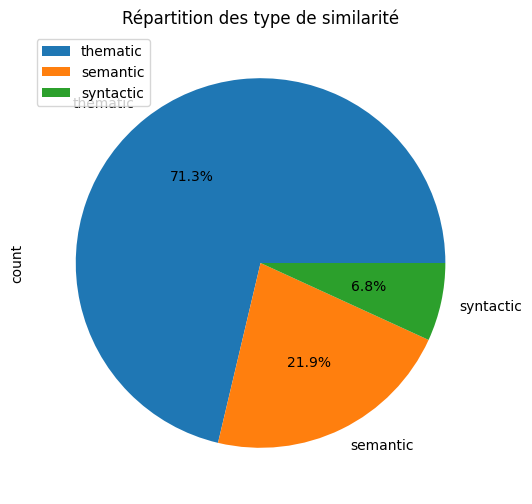

In [239]:
counts = reference_base['type_similarite'].value_counts()
pourcentages = counts / counts.sum() * 100

reference_base['type_similarite'].value_counts().plot(kind='pie',
                                       figsize=(6, 6),
                                       title='Répartition des type de similarité',
                                       fontsize=10,
                                       autopct='%1.1f%%',
                                       legend=True)
plt.legend(loc='upper left')
plt.show()

#Classification

##Vectorisation : TF-IDF

In [240]:
vectorizer = TfidfVectorizer()


## {Syntaxique} vs. {Topic} vs. {semantique}

In [254]:
seed=53
Sk_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [266]:
from sklearn.preprocessing import OrdinalEncoder

#encoder = OrdinalEncoder()
X = vectorizer.fit_transform(reference_base['ckg'] + ' ' + reference_base['fnn'])
X=X.toarray()

lbl = LabelEncoder()
y = lbl.fit_transform(reference_base['type_similarite'])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=seed)

In [275]:
model = GaussianNB()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on test set:', accuracy)

cv_scores1 = cross_val_score(model, X, y, cv=Sk_fold)

print('Cross-validation scores:', cv_scores1)
print('Mean cross-validation score:', cv_scores1.mean())
print('Classification Report on test set:')
print(classification_report(y_test, y_pred, target_names=lbl.classes_))

Accuracy on test set: 0.678714859437751
Cross-validation scores: [0.6746988  0.69076305 0.69076305 0.74698795 0.68548387]
Mean cross-validation score: 0.6977393444746729
Classification Report on test set:
              precision    recall  f1-score   support

    semantic       0.42      0.27      0.33        66
   syntactic       0.18      0.11      0.13        19
    thematic       0.76      0.91      0.83       164

    accuracy                           0.68       249
   macro avg       0.45      0.43      0.43       249
weighted avg       0.63      0.68      0.64       249



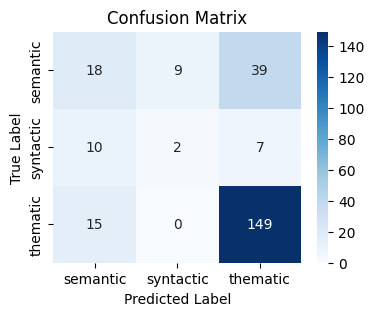

In [276]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lbl.classes_, yticklabels=lbl.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
ckg_vectors = vectorizer.fit_transform(topic_df['headline'])
fnn_vectors = vectorizer.transform(fnn['title'])

similarities = cosine_similarity(ckg_vectors, fnn_vectors)

ckg_indices, fnn_indices = np.where(similarities >= 0.6)

resulting_pairs = []
for ckg_index, fnn_index in zip(ckg_indices, fnn_indices):
    ckg_title = topic_df.iloc[ckg_index]['headline']
    fnn_title = fnn.iloc[fnn_index]['title']
    similarity = similarities[ckg_index, fnn_index]
    topic = topic_df.iloc[ckg_index]['topic']
    resulting_pairs.append({'CKG': ckg_title, 'FNN': fnn_title, 'Similarity': similarity, 'Topic': topic})

base_2 = pd.DataFrame(resulting_pairs)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
ckg_vectors = vectorizer.fit_transform(topic_df['headline'])
fnn_vectors = vectorizer.transform(fnn['title'])

similarities = cosine_similarity(ckg_vectors, fnn_vectors)

ckg_indices, fnn_indices = np.where(similarities >= 0.6)

resulting_pairs = []
for ckg_index, fnn_index in zip(ckg_indices, fnn_indices):
    ckg_title = topic_df.iloc[ckg_index]['headline']
    fnn_title = fnn.iloc[fnn_index]['title']
    similarity = similarities[ckg_index, fnn_index]
    topic = topic_df.iloc[ckg_index]['topic']
    resulting_pairs.append({'CKG': ckg_title, 'FNN': fnn_title, 'Similarity': similarity, 'Topic': topic})

base_2 = pd.DataFrame(resulting_pairs)


In [ ]:
topic_df.shape

(13917, 3)

In [ ]:
# Créer des dataframes séparés pour chaque sujet
political_df = topic_df[topic_df['topic'] == 'Political'].copy()
economic_df = topic_df[topic_df['topic'] == 'Economic'].copy()
social_df = topic_df[topic_df['topic'] == 'Social'].copy()


In [ ]:
social_df

,headline,topic,indice_ckg
134,kelli ayott compar size feder deficit basebal ...,Social,134
140,rand paul say feder program incentiv polic mil...,Social,140
158,true hillari clinton say feder govern su donal...,Social,158
256,feder inmat popul drop obama first time sinc c...,Social,256
335,feder stat back agricultur death claim,Social,335
...,...,...,...
8828,real video nadal feder laugh djokov,Social,8828
9268,feder relief dollar san francisco pay pot alco...,Social,9268
9314,censu respons affect whether get feder stimulu...,Social,9314
9348,paul herman cain call feder reserv critic ignor,Social,9348


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
ckg_vectors = vectorizer.fit_transform(topic_df['headline'])
fnn_vectors = vectorizer.transform(fnn['title'])

similarities = cosine_similarity(ckg_vectors, fnn_vectors)

ckg_indices, fnn_indices = np.where(similarities >= 0.6)

resulting_pairs = []
for ckg_index, fnn_index in zip(ckg_indices, fnn_indices):
    ckg_title = topic_df.iloc[ckg_index]['headline']
    fnn_title = fnn.iloc[fnn_index]['title']
    similarity = similarities[ckg_index, fnn_index]
    topic = topic_df.iloc[ckg_index]['topic']
    resulting_pairs.append({'CKG': ckg_title, 'FNN': fnn_title, 'Similarity': similarity, 'Topic': topic})

base_2 = pd.DataFrame(resulting_pairs)


In [ ]:
base_2.shape

(167, 4)

In [ ]:
base_2

,CKG,FNN,Similarity,Topic
0,hanniti say obama even use term war terror,hanniti say obama even use term war terror,1.000000,Economic
1,mccain say obama czar romanov,czar romanov,0.873150,Economic
2,ryan plan includ billion medicar cut say steph...,ryan plan includ billion medicar cut say steph...,1.000000,Political
3,rick perri say switch gop younger age reagan,rick perri say switch gop younger age reagan,1.000000,Economic
4,reid say republican use reconcili democrat,harri reid say gop stop cri reconcili,0.617115,Economic
...,...,...,...,...
162,proof melania trump said isi harm son scratch ...,melania trump isi lay finger barron scratch ob...,0.604899,Economic
163,alabama poll worker arrest senat elect,alabama state polic arrest poll worker birmingham,0.797618,Economic
164,maxin water face crimin charg,maxin water get crimin charg,0.835373,Political
165,hillari clinton furiou melania trump hospit gift,hillari clinton furiou special gift melania tr...,0.791659,Economic


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
ckg_vectors = vectorizer.fit_transform(social_df['headline'])
fnn_vectors = vectorizer.transform(fnn['title'])

similarities = cosine_similarity(ckg_vectors, fnn_vectors)

ckg_indices, fnn_indices = np.where(similarities >= 0.8)

resulting_pairs = []
for ckg_index, fnn_index in zip(ckg_indices, fnn_indices):
    ckg_title = social_df.iloc[ckg_index]['headline']
    fnn_title = fnn.iloc[fnn_index]['title']
    similarity = similarities[ckg_index, fnn_index]
    topic = social_df.iloc[ckg_index]['topic']
    resulting_pairs.append({'CKG': ckg_title, 'FNN': fnn_title, 'Similarity': similarity, 'Topic': topic})

base_so = pd.DataFrame(resulting_pairs)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
ckg_vectors = vectorizer.fit_transform(economic_df['headline'])
fnn_vectors = vectorizer.transform(fnn['title'])

similarities = cosine_similarity(ckg_vectors, fnn_vectors)

ckg_indices, fnn_indices = np.where(similarities >= 0.8)

resulting_pairs = []
for ckg_index, fnn_index in zip(ckg_indices, fnn_indices):
    ckg_title = economic_df.iloc[ckg_index]['headline']
    fnn_title = fnn.iloc[fnn_index]['title']
    similarity = similarities[ckg_index, fnn_index]
    topic = economic_df.iloc[ckg_index]['topic']
    resulting_pairs.append({'CKG': ckg_title, 'FNN': fnn_title, 'Similarity': similarity, 'Topic': topic})

base_eco = pd.DataFrame(resulting_pairs)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
ckg_vectors = vectorizer.fit_transform(political_df['headline'])
fnn_vectors = vectorizer.transform(fnn['title'])

similarities = cosine_similarity(ckg_vectors, fnn_vectors)

ckg_indices, fnn_indices = np.where(similarities >= 0.8)

resulting_pairs = []
for ckg_index, fnn_index in zip(ckg_indices, fnn_indices):
    ckg_title = political_df.iloc[ckg_index]['headline']
    fnn_title = fnn.iloc[fnn_index]['title']
    similarity = similarities[ckg_index, fnn_index]
    topic = political_df.iloc[ckg_index]['topic']
    resulting_pairs.append({'CKG': ckg_title, 'FNN': fnn_title, 'Similarity': similarity, 'Topic': topic})

base_po = pd.DataFrame(resulting_pairs)


In [ ]:
base_eco

,CKG,FNN,Similarity,Topic
0,ryan plan includ billion medicar cut say steph...,ryan plan includ billion medicar cut say steph...,1.000000,Economic
1,rick perri say switch gop younger age reagan,rick perri say switch gop younger age reagan,1.000000,Economic
2,ryan plan includ billion medicar cut say steph...,ryan plan includ billion medicar cut say steph...,1.000000,Economic
3,warren buffett say super rich pay lower tax ra...,warren buffett say super rich pay lower tax ra...,1.000000,Economic
4,rep paul gosar ask polic arrest illeg immigr s...,rep paul gosar ask capitol polic arrest illeg ...,0.877279,Economic
5,ryan plan includ billion medicar cut say steph...,ryan plan includ billion medicar cut say steph...,1.000000,Economic
6,ryan plan includ billion medicar cut say steph...,ryan plan includ billion medicar cut say steph...,1.000000,Economic
7,ryan plan includ billion medicar cut say steph...,ryan plan includ billion medicar cut say steph...,1.000000,Economic
8,warren buffett say super rich pay lower tax ra...,warren buffett say super rich pay lower tax ra...,1.000000,Economic
9,rick perri say switch gop younger age reagan,rick perri say switch gop younger age reagan,1.000000,Economic


In [ ]:
base_po

,CKG,FNN,Similarity,Topic
0,hanniti say obama even use term war terror,hanniti say obama even use term war terror,1.000000,Political
1,mccain say obama czar romanov,czar romanov,0.877537,Political
2,boehner claim hous republican domin twitter yo...,pwned hous gop domin twitter youtub social med...,0.875288,Political
3,republican consult say barack obama promis hal...,republican consult say barack obama promis hal...,1.000000,Political
4,boehner claim hous republican domin twitter yo...,pwned hous gop domin twitter youtub social med...,0.875288,Political
5,republican consult say barack obama promis hal...,republican consult say barack obama promis hal...,1.000000,Political
6,hanniti say obama even use term war terror,hanniti say obama even use term war terror,1.000000,Political
7,hanniti say obama even use term war terror,hanniti say obama even use term war terror,1.000000,Political
8,heroin come across mexican border rob portman say,heroin come across mexican border rob portman say,1.000000,Political
9,heroin come across mexican border rob portman say,heroin come across mexican border rob portman say,1.000000,Political


In [ ]:
len(base_eco)

41

In [ ]:
base_2

,CKG,FNN,Similarity,Topic
0,hanniti say obama even use term war terror,hanniti say obama even use term war terror,1.000000,Political
1,mccain say obama czar romanov,czar romanov,0.873097,Political
2,ryan plan includ billion medicar cut say steph...,ryan plan includ billion medicar cut say steph...,1.000000,Economic
3,rick perri say switch gop younger age reagan,rick perri say switch gop younger age reagan,1.000000,Economic
4,boehner claim hous republican domin twitter yo...,pwned hous gop domin twitter youtub social med...,0.878875,Political
...,...,...,...,...
61,major state ban sharia law,state ban sharia law support christmasgift,0.821706,Economic
62,laura ingraham wrongli say claim support gun b...,laura ingraham wrongli say claim support gun b...,1.000000,Political
63,proof pope franci said jesu metaphor,pope franci mass jesu metaphor liter,0.835570,Political
64,fake news claim melania trump hire exorcist cl...,melania trump hire exorcist cleans white hous ...,0.899564,Political


In [ ]:
unique_pairs = set()

for ckg_index, ckg_row in topic_df.iterrows():
    ckg_title = ckg_row['headline']
    ckg_topic = ckg_row['topic']

    matching_fnn_titles = fnn[fnn['title'].str.contains(ckg_topic, case=False, na=False)]['title'].tolist()

    for fnn_title in matching_fnn_titles:
        pair = (ckg_title, fnn_title, ckg_topic)
        unique_pairs.add(pair)

result_df = pd.DataFrame(unique_pairs, columns=['CKG', 'FNN', 'topic'])

In [ ]:
result_df.shape

(940, 3)

In [ ]:
result_df

,CKG,FNN,topic
0,covid vaccin oper system run bill gate,social secur onlin histori page,Social
1,bill clinton say obama administr tri boost wor...,senat berni sander democrat social unit state,Social
2,charli crist say endors stimulu bill,social secur truste report,Social
3,u make progress cut greenhous ga emiss compar ...,social secur onlin histori page,Social
4,northam cut power kill virginian refus give gun,social secur truste report,Social
...,...,...,...
935,del kathi tran wrong say bill chang late term ...,democrat debat berni sander realli socialist p...,Social
936,bill polic fire wisconsin phone fee noth lawma...,pwned hous gop domin twitter youtub social med...,Social
937,bill mccollum claim recov nearli million medic...,social secur truste report,Social
938,ohio treasur kevin boyc twice cut pay,democrat debat berni sander realli socialist p...,Social


In [ ]:
unique_pairs = set()

for ckg_index, ckg_row in political_df.iterrows():
    ckg_title = ckg_row['headline']
    ckg_topic = ckg_row['topic']

    matching_fnn_titles = fnn[fnn['title'].str.contains(ckg_topic, case=False, na=False)]['title'].tolist()

    for fnn_title in matching_fnn_titles:
        pair = (ckg_title, fnn_title, ckg_topic)
        unique_pairs.add(pair)

result_df_po = pd.DataFrame(unique_pairs, columns=['CKG', 'FNN', 'topic'])

In [ ]:
unique_pairs = set()

for ckg_index, ckg_row in economic_df.iterrows():
    ckg_title = ckg_row['headline']
    ckg_topic = ckg_row['topic']

    matching_fnn_titles = fnn[fnn['title'].str.contains(ckg_topic, case=False, na=False)]['title'].tolist()

    for fnn_title in matching_fnn_titles:
        pair = (ckg_title, fnn_title, ckg_topic)
        unique_pairs.add(pair)

result_df_eco = pd.DataFrame(unique_pairs, columns=['CKG', 'FNN', 'topic'])

In [ ]:
unique_pairs = set()

for ckg_index, ckg_row in social_df.iterrows():
    ckg_title = ckg_row['headline']
    ckg_topic = ckg_row['topic']

    matching_fnn_titles = fnn[fnn['title'].str.contains(ckg_topic, case=False, na=False)]['title'].tolist()

    for fnn_title in matching_fnn_titles:
        pair = (ckg_title, fnn_title, ckg_topic)
        unique_pairs.add(pair)

result_df_so = pd.DataFrame(unique_pairs, columns=['CKG', 'FNN', 'topic'])

In [ ]:
result_df_so

,CKG,FNN,topic
0,rhode island societi prevent cruelti anim chie...,pwned hous gop domin twitter youtub social med...,Social
1,john loughlin say rhode island gener assembl o...,democrat debat berni sander realli socialist p...,Social
2,rhode island state rep michael chippendal say ...,democrat debat berni sander realli socialist p...,Social
3,anti casino activist say rhode island get reve...,pwned hous gop domin twitter youtub social med...,Social
4,rhode island rep teresa tanzi say content elec...,senat berni sander democrat social unit state,Social
...,...,...,...
270,univers rhode island presid david dooley say a...,social secur truste report,Social
271,rhode island gov lincoln chafe say submit stat...,senat berni sander democrat social unit state,Social
272,watchdog group critic stimulu spend publish re...,social secur truste report,Social
273,rhode island societi prevent cruelti anim chie...,social secur truste report,Social


In [ ]:
result_df_eco

,CKG,FNN,topic


In [ ]:
result_df_po

,CKG,FNN,topic


In [ ]:
result_df

,CKG,FNN,topic
0,romney say feder regul quadrupl obama,pwned hous gop domin twitter youtub social med...,Social
1,african american hispan poverti time low,social secur onlin histori page,Social
2,west virginia nation fourth worst poverti rate,social secur truste report,Social
3,african american hispan poverti time low,senat berni sander democrat social unit state,Social
4,entitl program debt swamp feder revenu near futur,social secur truste report,Social
...,...,...,...
425,mark warner say feder spend near time high rel...,social secur truste report,Social
426,joe biden want impos feder tax home,senat berni sander democrat social unit state,Social
427,jeff kottkamp took feder govern court say,democrat debat berni sander realli socialist p...,Social
428,ye feder abort law overturn wisconsin law coul...,democrat debat berni sander realli socialist p...,Social


In [ ]:
result_df['topic'].value_counts()


topic
Social    430
Name: count, dtype: int64

In [ ]:
base_2

,CKG,FNN,Similarity,Topic
0,hanniti say obama even use term war terror,hanniti say obama even use term war terror,1.000000,Economic
1,mccain say obama czar romanov,czar romanov,0.874254,Economic
2,ryan plan includ billion medicar cut say steph...,ryan plan includ billion medicar cut say steph...,1.000000,Economic
3,rick perri say switch gop younger age reagan,rick perri say switch gop younger age reagan,1.000000,Economic
4,boehner claim hous republican domin twitter yo...,pwned hous gop domin twitter youtub social med...,0.875658,Political
...,...,...,...,...
65,major state ban sharia law,state ban sharia law support christmasgift,0.833045,Political
66,laura ingraham wrongli say claim support gun b...,laura ingraham wrongli say claim support gun b...,1.000000,Economic
67,proof pope franci said jesu metaphor,pope franci mass jesu metaphor liter,0.834402,Economic
68,fake news claim melania trump hire exorcist cl...,melania trump hire exorcist cleans white hous ...,0.903404,Political


In [ ]:
len(topic_df)

4114

In [ ]:

keyword_to_topic = defaultdict(str)
for index, row in voc.iterrows():
    for word in row['vocabulary'].split(', '):
        keyword_to_topic[word] = row['Topic']

def assign_topic(title):
    for word in title.split():
        if word.lower() in keyword_to_topic:
            return keyword_to_topic[word.lower()]

fnn['topic'] = fnn['title'].apply(assign_topic)

topic_fnn = fnn.dropna(subset=['topic'])

topic_df1 = topic_fnn[['title', 'topic']].copy()

topic_df1['indice_fnn'] = topic_fnn.index


In [ ]:
topic_df1

,title,topic,indice_fnn
5,donald trump exagger say china total control n...,Social,5
17,prevent flu good health habit help stop germ,Political,17
20,rand paul campaign iowa miller meek,Economic,20
22,hillari clinton say gun exceed next nine categ...,Political,22
25,politifact annot transcript second presidenti ...,Political,25
...,...,...,...
403,access aug,Social,403
413,account suspend,Social,413
420,rep paul gosar ask capitol polic arrest illeg ...,Social,420
424,singer dolli parton trump one year alreadi bet...,Political,424


In [ ]:
topic_df1.value_counts('topic')

topic
Political    78
Economic     37
Social       37
Name: count, dtype: int64

In [ ]:
len(topic_df1)

152

In [ ]:
merged_df = pd.merge(topic_df, topic_df1, on='topic')

base_2 = merged_df[['headline', 'title', 'topic']].rename(columns={'headline': 'CKG', 'title': 'FNN'})


In [ ]:
base_2

,CKG,FNN,topic
0,nami ohio leader terri russel say peopl mental...,prevent flu good health habit help stop germ,Political
1,nami ohio leader terri russel say peopl mental...,hillari clinton say gun exceed next nine categ...,Political
2,nami ohio leader terri russel say peopl mental...,politifact annot transcript second presidenti ...,Political
3,nami ohio leader terri russel say peopl mental...,gop task forc lone democrat eye traffick law,Political
4,nami ohio leader terri russel say peopl mental...,watch replay fox news presidenti debat,Political
...,...,...,...
226300,claim solar panel drain sun energi satir scienc,trump warn russia jehovah wit ban urg member s...,Economic
226301,claim solar panel drain sun energi satir scienc,updat florida governor rick scott list,Economic
226302,claim solar panel drain sun energi satir scienc,trueamerican nbspthi websit sale nbsptrueameri...,Economic
226303,claim solar panel drain sun energi satir scienc,famili privat investig evid seth rich contact ...,Economic


In [ ]:
base_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226305 entries, 0 to 226304
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   CKG     226305 non-null  object
 1   FNN     226305 non-null  object
 2   topic   226305 non-null  object
dtypes: object(3)
memory usage: 5.2+ MB


In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.4 MB/s eta 0:00:00


In [ ]:
import umap.umap_ as umap

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_ckg = tfidf_vectorizer.fit_transform(result_df['CKG'])

tfidf_matrix_fnn = tfidf_vectorizer.transform(result_df['FNN'])

umap_model = umap.UMAP(n_components=3)
tfidf_matrix_ckg_umap = umap_model.fit_transform(tfidf_matrix_ckg)
tfidf_matrix_fnn_umap = umap_model.transform(tfidf_matrix_fnn)

In [ ]:
# Calculer la similarité cosinus entre les titres CKG et FNN réduits
cosine_similarities_umap = cosine_similarity(tfidf_matrix_ckg_umap, tfidf_matrix_fnn_umap)

similarities_df = pd.DataFrame(cosine_similarities_umap, index=base_2.index, columns=base_2.index)

most_similar_pairs = []
for index, row in baresult_dfse_2.iterrows():
    topic = row['topic']
    same_topic_rows = base_2[result_df['topic'] == topic]
    similar_row_indices = similarities_df.loc[same_topic_rows.index, index].idxmax()
    most_similar_pairs.append((row['headline'], same_topic_rows.loc[similar_row_indices]['headline'], topic, similarities_df.loc[similar_row_indices, index]))

base_topic = pd.DataFrame(most_similar_pairs, columns=['CKG', 'FNN', 'Topic', 'Similarity'])

ValueError: Shape of passed values is (1405, 1405), indices imply (167, 167)

In [ ]:
"""
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Créer une liste de documents où chaque document est une liste de mots
documents = [headline.lower().split() for headline in ckg['headline']]

# Créer le dictionnaire Gensim à partir des documents
dictionary = Dictionary(documents)

# Filtrer les tokens peu fréquents et très fréquents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Créer la représentation de sac de mots des documents
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Entraîner le modèle LDA
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)

# Obtenir les attributions de sujet pour chaque document
topic_assignments = lda_model.get_document_topics(corpus)

# Créer un DataFrame pour stocker les résultats
topic_df = pd.DataFrame(columns=['headline', 'topic'])

# Remplir le DataFrame avec les titres et les sujets attribués
for i, topics in enumerate(topic_assignments):
    dominant_topic = max(topics, key=lambda x: x[1])[0]
    topic_df = topic_df.append({'headline': ckg['headline'][i], 'topic': dominant_topic}, ignore_index=True)
# Ajouter l'indice d'origine de ckg comme colonne dans topic_df
topic_df['indice_ckg'] = topic_df.index
"""

"\nfrom gensim.models import LdaModel\nfrom gensim.corpora import Dictionary\n\n# Créer une liste de documents où chaque document est une liste de mots\ndocuments = [headline.lower().split() for headline in ckg['headline']]\n\n# Créer le dictionnaire Gensim à partir des documents\ndictionary = Dictionary(documents)\n\n# Filtrer les tokens peu fréquents et très fréquents\ndictionary.filter_extremes(no_below=5, no_above=0.5)\n\n# Créer la représentation de sac de mots des documents\ncorpus = [dictionary.doc2bow(doc) for doc in documents]\n\n# Entraîner le modèle LDA\nlda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)\n\n# Obtenir les attributions de sujet pour chaque document\ntopic_assignments = lda_model.get_document_topics(corpus)\n\n# Créer un DataFrame pour stocker les résultats\ntopic_df = pd.DataFrame(columns=['headline', 'topic'])\n\n# Remplir le DataFrame avec les titres et les sujets attribués\nfor i, topics in enumerate(topic_assignments):\n    dominant_

Sélection des topics plus similaire


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

topic_similarity_matrix = cosine_similarity(ckg_topics, fnn_topics)

similar_topic_pairs = []

for ckg_index, fnn_index in zip(*topic_similarity_matrix.nonzero()):
    ckg_topic = ckg_topics[ckg_index].argmax()
    similar_topic_pairs.append([ckg_index, fnn_index, ckg_texts[ckg_index], fnn_texts[fnn_index], ckg_topic])

similar_topic_pairs.sort(key=lambda x: x[4], reverse=True)

selected_pairs = similar_topic_pairs[:1000]

unique_pairs = set()

for ckg_index, fnn_index, _, _, topic in selected_pairs:
    unique_pairs.add((ckg_index, fnn_index, ckg_texts[ckg_index], fnn_texts[fnn_index], topic))

unique_pairs = list(unique_pairs)

base_2 = pd.DataFrame(unique_pairs, columns=['Indice_ckg', 'Indice_fnn', 'ckg', 'fnn', 'Topic'])


     Indice_ckg  Indice_fnn  \
0             6         187   
1             6         831   
2             6         306   
3             6         595   
4             6         878   
..          ...         ...   
995           6         685   
996           6         518   
997           6         290   
998           6         655   
999           6         224   

                                                   ckg  \
0    ye polic gave kyle rittenh water thank arm gro...   
1    ye polic gave kyle rittenh water thank arm gro...   
2    ye polic gave kyle rittenh water thank arm gro...   
3    ye polic gave kyle rittenh water thank arm gro...   
4    ye polic gave kyle rittenh water thank arm gro...   
..                                                 ...   
995  ye polic gave kyle rittenh water thank arm gro...   
996  ye polic gave kyle rittenh water thank arm gro...   
997  ye polic gave kyle rittenh water thank arm gro...   
998  ye polic gave kyle rittenh water thank arm

In [ ]:
base_2.ckg[2]

'ye polic gave kyle rittenh water thank arm group kenosha shoot'

In [ ]:
base_2.fnn[2]

'resourc avail'

In [ ]:
base_2.Topic[450]

4

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
topic = lbl.fit_transform(ckg_topic['topic'])

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(ckg_topic['headline'])

model = LogisticRegression(max_iter=1000)
model.fit(X_train, topic)

X_test = vectorizer.transform(fnn_clean['title'])
predicted_topics = model.predict(X_test)

predicted_topics = lbl.inverse_transform(predicted_topics)

fnn_topic = pd.DataFrame({
                       'fnn': fnn_clean['title'].tolist(),
                       'topic': predicted_topics})


In [ ]:
vectorizer = TfidfVectorizer()

ckg_texts = ckg_0['headline'].tolist()
fnn_texts = fnn_0['fnn'].tolist()

matrix_ckg = vectorizer.fit_transform(ckg_texts)
matrix_fnn = vectorizer.transform(fnn_texts)

similarities = cosine_similarity(matrix_ckg, matrix_fnn)

similar_pairs = []

for i, ckg_text in enumerate(ckg_texts):
    for j, fnn_text in enumerate(fnn_texts):
        similarity_score = similarities[i][j]
        similar_pairs.append((ckg_text, fnn_text, similarity_score))

sim_0 = pd.DataFrame(similar_pairs, columns=['ckg', 'fnn', 'Similarity'])
sim_0.drop_duplicates(inplace=True, subset=['ckg', 'fnn', 'Similarity'])